<a href="https://colab.research.google.com/github/itchyfeet-patient/Going_Deeper/blob/master/CAM/%5BGD_5%5DClass_Activation_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **10-9. ÌîÑÎ°úÏ†ùÌä∏: CAMÏùÑ ÎßåÎì§Í≥† ÌèâÍ∞ÄÌï¥ Î≥¥Ïûê**

## **0. ÎùºÏù¥Î∏åÎü¨Î¶¨ Î≤ÑÏ†Ñ ÌôïÏù∏ÌïòÍ∏∞**
ÏÇ¨Ïö©Ìï† ÎùºÏù¥Î∏åÎü¨Î¶¨ Î≤ÑÏ†ÑÏùÑ ÌôïÏù∏Ìï¥Î¥êÏöî.

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import copy
import cv2
from PIL import Image

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(Image.__version__)

2.9.2
1.21.6
4.6.0
7.1.2


## **1. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞**

In [2]:
# ÏµúÏ¥à ÏàòÌñâÏãúÏóêÎäî Îã§Ïö¥Î°úÎìúÍ∞Ä ÏßÑÌñâÎê©ÎãàÎã§. Ïò§Îûò Í±∏Î¶¥ Ïàò ÏûàÏúºÎãà Ïú†ÏùòÌï¥ Ï£ºÏÑ∏Ïöî.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('Ïäù=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteJFBQPN/stanford_dogs-train.tfrecord*...:   0%|  ‚Ä¶

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteJFBQPN/stanford_dogs-test.tfrecord*...:   0%|   ‚Ä¶

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
Ïäù=3


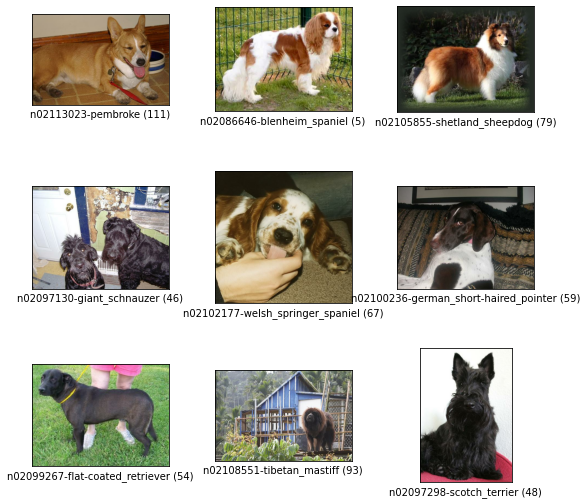

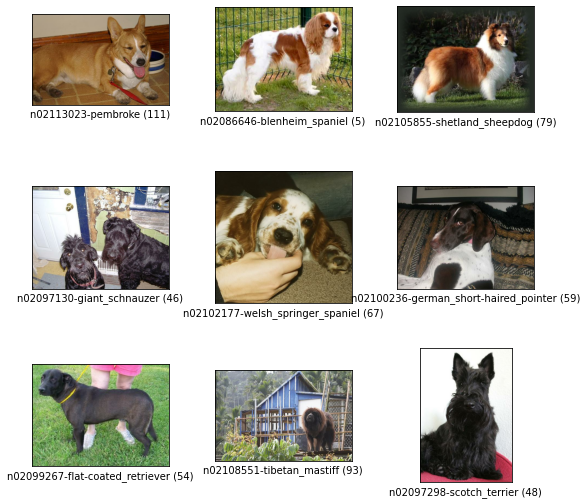

In [3]:
tfds.show_examples(ds_train, ds_info)

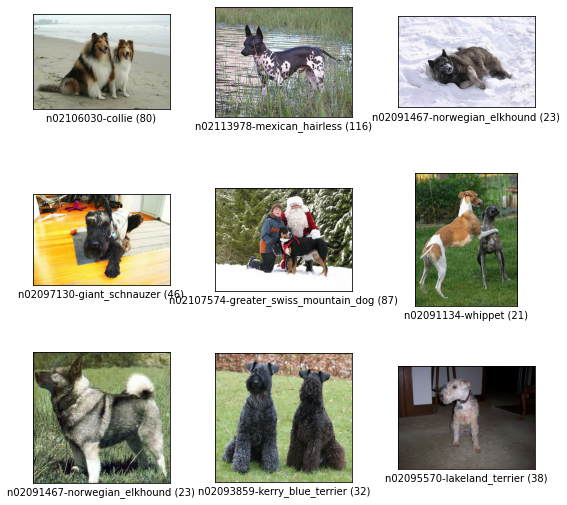

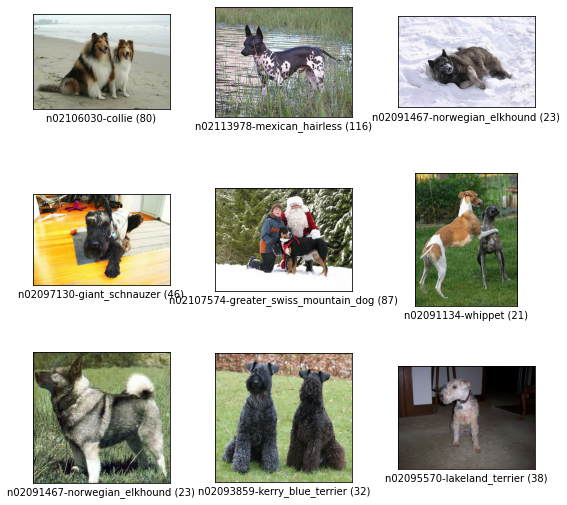

In [4]:
tfds.show_examples(ds_test, ds_info)

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## **2. CAM Íµ¨ÌòÑÌïòÍ∏∞**
> Ïù¥Î≤à ÎÖ∏ÎìúÏóê ÎÇòÏôîÎçò CAMÏùÑ ÏßÅÏ†ë Íµ¨ÌòÑÌï¥ Î¥ÖÏãúÎã§.

### **CAM**

Í∞ùÏ≤¥ ÏúÑÏπò Ï∂îÏ∂úÏù¥ Í∞ÄÎä•Ìïú Î™®Îç∏ Íµ¨Ï°∞Ïù∏ CAMÏùÑ ÎßåÎì§Ïñ¥Î¥ÖÏãúÎã§. Í∏∞Ï°¥ Ïù¥ÎØ∏ÏßÄ Î∂ÑÎ•òÎ™®Îç∏ÏóêÏÑú ÎßàÏßÄÎßâ Ïó¨Îü¨Ï∏µÏùò FC layerÏóê ÏùòÌï¥ flatten ÎêòÎØÄÎ°ú ÏúÑÏπòÏ†ïÎ≥¥Í∞Ä ÏÜåÏã§ÎêòÎÇò,  
CAMÏóêÏÑúÎäî GAPÎ•º Ïù¥Ïö©ÌïòÍ≥† FC layerÎèÑ ÌïòÎÇòÎßå ÏÇ¨Ïö©Ìï¥ÏÑú ÏúÑÏπòÏ†ïÎ≥¥Î•º ÏÇ¥Î¶ΩÎãàÎã§.

Í≤∞Î°† : ÎßàÏßÄÎßâ Ï∏µÏóêÏÑú GAP ÏÇ¨Ïö©ÌïòÍ∏∞

### **(1) CAM Î™®Îç∏ ÎßåÎì§Í∏∞**

In [6]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet Î∂ÑÎ•òÍ∏∞  fully connected layer Ï†úÍ±∞
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAPÎ•º Ï†ÅÏö©  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94765736/94765736 [==============================] - 0s 0us/step


In [7]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

### **(2) Í∞ÑÎã®Ìïú Ï†ÑÏ≤òÎ¶¨**

In [8]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('Ïäù=3')

Ïäù=3


In [9]:
# Îç∞Ïù¥ÌÑ∞ÏÖãÏóê Ï†ÑÏ≤òÎ¶¨ÏôÄ Î∞∞ÏπòÏ≤òÎ¶¨Î•º Ï†ÅÏö©Ìï©ÎãàÎã§. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# Íµ¨ÏÑ±Îêú Î∞∞ÏπòÏùò Î™®ÏñëÏùÑ ÌôïÏù∏Ìï¥ Î¥ÖÎãàÎã§. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


 ### **(3) Î™®Îç∏ ÌïôÏäµ**

In [10]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

print('Ïäù=3')

Ïäù=3


[earlystoppingÏ∞∏Í≥†](https://sevillabk.github.io/1-early-stopping/)

In [11]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# history_cam_model = cam_model.fit(
#     ds_train_norm,
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=50,
#     validation_data=ds_test_norm,
#     verbose=1,
#     use_multiprocessing=True,
#     callbacks=[es]
# )

In [12]:
# import os

# cam_model_path = '/content/drive/MyDrive/dataset/class_activation_map/cam_model1.h5'
# cam_model.save(cam_model_path)
# print("Ï†ÄÏû• ÏôÑÎ£å!")

50 Epoch ÌïôÏäµÏãúÌÇ§Í≥† Ï†ÄÏû•Ìï¥Ï§¨ÏäµÎãàÎã§.

Ïù¥Ï†ú ÌïôÏäµÎêú Î™®Îç∏ÏóêÏÑú CAMÏùÑ ÏÉùÏÑ±ÌïòÍ∏∞ ÏúÑÌï¥ `get_one` Ìï®ÏàòÎ•º Ï†ïÏùòÌï¥ Ï§çÎãàÎã§.  
Î∞∞ÏπòÎã®ÏúÑÍ∞Ä ÏïÑÎãàÎùº Í∞úÎ≥Ñ Ïù¥ÎØ∏ÏßÄ Îç∞Ïù¥ÌÑ∞ Îã®ÏúÑÎ°ú Ïù¥Î§ÑÏßÄÎØÄÎ°ú, Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú Ìïú Ïû•Ïî© ÎΩëÍ≤å ÌñàÏäµÎãàÎã§.

In [13]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('Ïäù=3')

Ïäù=3


108


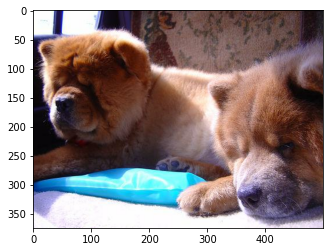

In [14]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

Îç∞Ïù¥ÌÑ∞Í∞Ä Ï§ÄÎπÑÎêòÏóàÏúºÎãà CAMÏùÑ ÏÉùÏÑ±ÌïòÍ∏∞ ÏúÑÌï¥ ÎØ∏Î¶¨ Ï§ÄÎπÑÎêú ÌïôÏäµÎ™®Îç∏ÏùÑ Î∂àÎü¨ÏôÄÎ¥ÖÎãàÎã§.

In [24]:
cam_model_path = '/content/drive/MyDrive/dataset/class_activation_map/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
print('Ïäù=3')

Ïäù=3


CAMÏùÑ ÏÉùÏÑ±ÌïòÍ∏∞ ÏúÑÌï¥ÏÑúÎäî (1) ÌäπÏÑ± Îßµ, (2) ÌÅ¥ÎûòÏä§Î≥Ñ ÌôïÎ•†ÏùÑ ÏñªÍ∏∞ ÏúÑÌïú ÏÜåÌîÑÌä∏Îß•Ïä§ Î†àÏù¥Ïñ¥Ïùò Í∞ÄÏ§ëÏπò, Í∑∏Î¶¨Í≥† (3) ÏõêÌïòÎäî ÌÅ¥ÎûòÏä§Ïùò Ï∂úÎ†•Í∞íÏù¥ ÌïÑÏöîÌï©ÎãàÎã§. Îòê Ïù¥ÎØ∏ÏßÄÏóêÏÑú Î™®Îç∏Ïù¥ Ïñ¥Îñ§ Î∂ÄÎ∂ÑÏùÑ Î≥¥ÎäîÏßÄ ÏßÅÍ¥ÄÏ†ÅÏúºÎ°ú ÌôïÏù∏ÌïòÎ†§Î©¥ ÎÑ§Ìä∏ÏõåÌÅ¨ÏóêÏÑú ÎÇòÏò® CAMÏùÑ ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶àÏôÄ Í∞ôÍ≤å ÎßåÎì§Ïñ¥ Ìï®Íªò ÏãúÍ∞ÅÌôîÌï¥Ïïº Ìï† Í≤ÉÏûÖÎãàÎã§. Ïù¥Î•º Í≥†Î†§Ìï¥ÏÑú modelÍ≥º itemÏùÑ Î∞õÏïòÏùÑ Îïå ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄÏôÄ ÎèôÏùºÌïú ÌÅ¨Í∏∞Ïùò CAMÏùÑ Î∞òÌôòÌïòÎäî Ìï®ÏàòÎ•º ÎßåÎì§Ïñ¥Ïïº Ìï©ÎãàÎã§.

generate_cam() ÏùÑ Íµ¨ÌòÑÌïòÍ∏∞ ÏúÑÌï¥ ÏïÑÎûòÏóêÏÑúÎäî conv_ouputsÏôÄ Í∞ôÏù¥ ÌäπÏ†ï Î†àÏù¥Ïñ¥Ïùò Í≤∞Í≥ºÍ∞íÏùÑ outputÏúºÎ°ú Î∞õÍ∏∞ ÏúÑÌï¥ ÏÉàÎ°úÏö¥ Î™®Îç∏ÏùÑ Ï†ïÏùòÌïòÍ≥†, feedforwardÎ•º Í±∞Ïπú ÌõÑ CAMÏùÑ Í≥ÑÏÇ∞ÌïòÎèÑÎ°ù Íµ¨ÌòÑÌïòÏòÄÏäµÎãàÎã§. ÎßàÏßÄÎßâÏóêÎäî ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¨Í∏∞Ïóê ÎßûÏ∂∞ CAMÏùÑ resizeÌï¥ Ï£ºÏóàÏäµÎãàÎã§.

**Ï∞∏Í≥†**  
[deepcopy](https://crackerjacks.tistory.com/m/14)  
: Î∞∞Ïó¥ÏùÑ ÍπäÏùÄ Î≥µÏÇ¨Ìï¥ÏÑú ÏõêÎ≥∏ Î∞∞Ïó¥Ïùò Î≥¥Ï°¥ÏùÑ ÌïòÍ∏∞ ÏúÑÌï¥ deepcopyÌï®  
Î¶¨Ïä§Ìä∏Î•º Î≥µÏÇ¨Ìï† Îïå, ÏñïÏùÄ Î≥µÏÇ¨Î•º ÌÜµÌï¥ Ï£ºÏÜåÍ∞íÎßå Î≥µÏÇ¨ÎêòÏñ¥ Î≥µÏÇ¨Îêú Í∞ùÏ≤¥ÏóêÏÑú Í∞íÏùÑ Î∞îÍæºÍ≤ÉÏù¥ ÏõêÎ≥∏ Í∞ùÏ≤¥Ïùò Í∞íÎèÑ Î∞îÍæ∏Îäî Í≤ÉÏùÑ ÎßâÍ∏∞ ÏúÑÌï¥ ÍπäÏùÄ Î≥µÏÇ¨Î•º ÏÇ¨Ïö©ÌïúÎã§.

In [27]:
def generate_cam(model, item):
    cam_image = None
    item = copy.deepcopy(item) # itemÏùÑ ÍπäÏùÄ Î≥µÏÇ¨Ìï®
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    img_tensor, class_idx = normalize_and_resize_img(item)
    # normalizeÌïòÍ≥† resizeÎêú imageÏôÄ labelÏù¥ Îã¥ÍπÄ

    # ÌïôÏäµÌïú Î™®Îç∏ÏóêÏÑú ÏõêÌïòÎäî layerÏùò outputÏùÑ ÏñªÍ∏∞ ÏúÑÌï¥ÏÑú Î™®Îç∏Ïùò inputÍ≥º outputÏùÑ ÏÉàÎ°≠Í≤å Ï†ïÏùò
    # model.layers[-3].outputÏóêÏÑúÎäî Ïö∞Î¶¨Í∞Ä ÌïÑÏöîÎ°ú ÌïòÎäî GAP Ïù¥Ï†Ñ convolution layerÏùò outputÏùÑ ÏñªÏùÑ Ïàò ÏûàÎã§
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs,predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]

    # Î™®Îç∏Ïùò weight activationÏùÄ ÎßàÏßÄÎßâ layerÏóê ÏûàÏäµÎãàÎãπ
    class_weights = model.layers[-1].get_weights()[0]

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputsÏùò iÎ≤àÏß∏ Ï±ÑÎÑêÍ≥º iÎ≤àÏß∏ weightÎ•º Í≥±Ìï¥ÏÑú ÎàÑÏ†ÅÌïòÎ©¥ ÌôúÏÑ±ÌôîÎêú Ï†ïÎèÑÍ∞Ä ÎÇòÌÉÄÎÇ®
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation scoreÎ•º normalizeÌïòÍ∏î
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

print("shoong~")

shoong~


> ÎßåÎì† Ìï®ÏàòÎ°ú CAM Ïù¥ÎØ∏ÏßÄÎ•º ÏÉùÏÑ±Ìï©ÏãúÎã§.

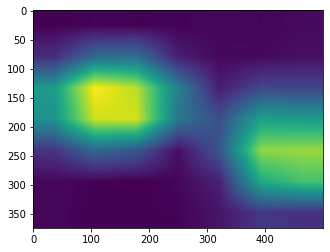

In [29]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

ÏúÑÏóê ÏÉòÌîåÏù¥ÎØ∏ÏßÄÎ•º Î≥¥Î©¥ Ï†ïÌôïÌïòÍ≤å ÏúÑÏπòÎ•º ÌëúÌòÑÌïòÍ≥† ÏûàÎÑ§Ïöî!

> ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÏôÄ CAM Ïù¥ÎØ∏ÏßÄÎ•º ÏûÖÎ†•ÏúºÎ°ú Î∞õÍ≥† Îëê Í∞úÏùò Ïù¥ÎØ∏ÏßÄÏùò Ìà¨Î™ÖÎèÑÎ•º Ï°∞Ï†ï, ÌïòÎÇòÏùò Ïù¥ÎØ∏ÏßÄÏóêÏÑú ÏõêÎ≥∏Í≥º CAMÏùÑ Í≤πÏ≥ê Î≥¥Ïó¨Ï£ºÎäî `visualize_cam_on_image()` Ìï®ÏàòÎ•º ÎßåÎì§Ïñ¥Î≥¥ÏÑ∏Ïöî.
* [webnautesÎãòÏùò OpenCV Python Í∞ïÏ¢å - Îëê Í∞úÏùò Ïù¥ÎØ∏ÏßÄ ÎçîÌïòÍ∏∞, Î∏îÎ†åÎî©](https://webnautes.tistory.com/1245)

In [30]:
def visualize_cam_on_image(image, cam_image, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0.0)
    return merged_image

---

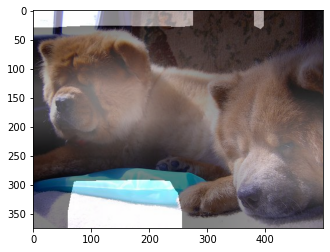

In [34]:
# visualize_cam_on_image() Ìï®Ïàò ÏÇ¨Ïö©

#type(item['image'].np())

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

Î©çÎ©çÏù¥ ÏñºÍµ¥Ïóê Ïûò Ï¥àÏ†êÏù¥ ÎßûÏ∂∞Ï†∏ÏûàÏäµÎãàÎã§.

## **3. Grad-CAM Íµ¨ÌòÑÌïòÍ∏∞**
> Ïù¥Î≤à ÎÖ∏ÎìúÏóê ÎÇòÏôîÎçò Grad-CAMÏùÑ ÏßÅÏ†ë Íµ¨ÌòÑÌï¥ Î¥ÖÏãúÎã§. ÏòàÏ†ú ÏΩîÎìúÎ•º ÏµúÎåÄÌïú Î≥¥ÏßÄ ÎßêÍ≥†, ÏÑ§Î™ÖÍ≥º Ïù¥Î°†ÏùÑ Î≥¥Í≥† Íµ¨ÌòÑÌï¥ Î≥¥ÏÑ∏Ïöî.

### **Grad-CAM**

Grad-CAM ÏùÄ Í¥ÄÏ∞∞ÏùÑ ÏõêÌïòÎäî Î†àÏù¥Ïñ¥ÏôÄ Ï†ïÎãµ ÌÅ¥ÎûòÏä§Ïóê ÎåÄÌïú ÏòàÏ∏°Í∞í ÏÇ¨Ïù¥Ïùò Í∑∏ÎûòÎîîÏñ∏Ìä∏Î•º Íµ¨ÌïòÍ≥†, Ïó¨Í∏∞Ïóê  GAP Ïó∞ÏÇ∞ÏùÑ Ï†ÅÏö©Ìï®ÏúºÎ°úÏç® Í¥ÄÏ∞∞ ÎåÄÏÉÅÏù¥ ÎêòÎäî Î†àÏù¥Ïñ¥Ïùò Ï±ÑÎÑêÎ≥Ñ Í∞ÄÏ§ëÏπòÎ•º Íµ¨Ìï©ÎãàÎã§. ÏµúÏ¢Ö CAMÏù¥ÎØ∏ÏßÄÎ•º Íµ¨ÌïòÍ∏∞ ÏúÑÌï¥ÏÑúÎäî Î†àÏù¥Ïñ¥Ïùò Ï±ÑÎÑêÎ≥Ñ Í∞ÄÏ§ëÏπò(Weights) ÏôÄ Î†àÏù¥Ïñ¥ÏóêÏÑú ÎÇòÏò® Ï±ÑÎÑêÎ≥Ñ ÌäπÏÑ±ÎßµÏùÑ Í∞ÄÏ§ëÌï©Ìï¥Ï£ºÏñ¥ cam_imageÎ•º ÏñªÍ≤åÎê©ÎãàÎã§.   
Ïù¥Ï†Ñ Ïä§ÌÖùÏóêÏÑú Î≥∏ CAMÌï®ÏàòÏôÄ Îã¨Î¶¨, grad-CAMÏùÄ Ïù¥Î≤àÏóêÎäî Ïñ¥Îñ§ Î†àÏù¥Ïñ¥Îì† CAMÏù¥ÎØ∏ÏßÄÎ•º ÎΩëÏïÑÎÇº Ïàò ÏûàÏúºÎØÄÎ°ú, Í∑∏ÎûòÎîîÏñ∏Ìä∏ Í≥ÑÏÇ∞ÏùÑ ÏõêÌïòÎäî Í¥ÄÏ∞∞ ÎåÄÏÉÅÏù¥ Î†àÏù¥Ïñ¥ activation_layerÎ•º ÎΩëÏïÑÏÑú Ïì∏ Ïàò ÏûàÎèÑÎ°ù activation_layerÏùò Ïù¥Î¶ÑÏùÑ Î∞õÍ≥† Ïù¥Î•º ÌôúÏö©Ìï¥Ïïº Ìï©ÎãàÎã§.  
ÏïÑÎûò `generate_grad_cam()`ÏóêÏÑúÎäî ÏõêÌïòÎäî Î†àÏù¥Ïñ¥Ïùò outputÍ≥º ÌäπÏ†ï ÌÅ¥ÎûòÏä§Ïùò prediction ÏÇ¨Ïù¥Ïùò Í∑∏ÎûòÎîîÏñ∏Ìä∏ grad_valÏùÑ ÏñªÍ≥† Ïù¥Î•º weightsÎ°ú ÌôúÏö©Ìï©ÎãàÎã§.

ÏùºÎã® ÏÉàÎ°úÏö¥ Ïù¥ÎØ∏ÏßÄÎ•º Í∞ÄÏ†∏ÏòµÎãàÎã§.

80


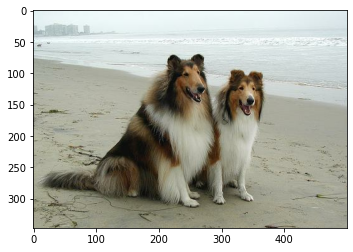

In [36]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [38]:
def generate_grad_cam(model, activation_layer, item):
    grad_cam_image = None
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

    # grad cam ÏóêÏÑúÎèÑ camÍ≥º Í∞ôÏù¥ ÌäπÏ†ï Î†àÏù¥Ïñ¥Ïùò outputÏùÑ ÌïÑÏöîÎ°ú ÌïòÎØÄÎ°ú Î™®Îç∏Ïùò inputÍ≥º
    # outputÏùÑ ÏÉàÎ°≠Í≤å Ï†ïÏùòÌï©ÎãàÎã§.
    # Ïù¥Îïå ÏõêÌïòÎäî Î†àÏù¥Ïñ¥Í∞Ä Îã§Î•º Ïàò ÏûàÏúºÎãà Ìï¥Îãπ Î†àÏù¥Ïñ¥Ïùò Ïù¥Î¶ÑÏúºÎ°ú Ï∞æÏùÄ ÌõÑ outputÏúºÎ°ú Ï∂îÍ∞Ä

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])

    # gradientÎ•º ÏñªÍ∏∞ ÏúÑÌï¥ tapeÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor,0))

        loss = pred[:, class_idx] 
        # ÏõêÌïòÎäî class(Ïó¨Í∏∞ÏÑúÎäî Ï†ïÎãµÏúºÎ°ú ÌôúÏö©), ÏòàÏ∏°Í∞í ÏñªÍ∏∞
        output = conv_output[0]
        # ÏõêÌïòÎäî layerÏùò outputÏùÑ ÏñªÏäµÎãàÎã§.
        grad_val = tape.gradient(loss, conv_output)[0]
        # ÏóêÏ∏°Í∞íÏóê Îî∞Î•∏ layerÏùò gradient ÏñªÍ∏∞

    weights = np.mean(grad_val, axis = (0,1))
    # gradientÏùò GAPÎ°ú weightÎ•º Íµ¨Ìï©ÎãàÎã§.
    grad_cam_image = np.zeros(dtype=np.float32, shape = conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # outputÏùò kÎ≤àÏß∏ Ï±ÑÎÑêÍ≥º kÎ≤àÏß∏ weightÎ•º Í≥±ÌïòÍ≥† ÎàÑÏ†ÅÌï¥ÏÑú class activation map ÏñªÍ∏∞

        grad_cam_image += w * output[:, :, k]

    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    
    return grad_cam_image

> ÎßåÎì† Ìï®ÏàòÎ°ú Ïó¨Îü¨ Î†àÏù¥Ïñ¥Ïùò CAM Ïù¥ÎØ∏ÏßÄÎ•º ÎΩëÏïÑÏÑú ÏßÅÏ†ë ÌôïÏù∏Ìï¥ Î≥¥ÏÑ∏Ïöî.




#### conv3_block3Ïùò CAM Ïù¥ÎØ∏ÏßÄÎ•º Ï∂úÎ†•

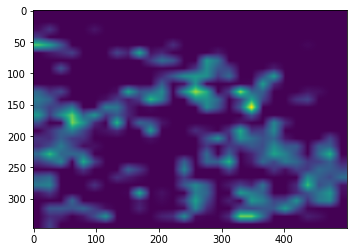

In [46]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

> ÏúÑÏóêÏÑú ÎßåÎì† Ïù¥ÎØ∏ÏßÄ `visualize_cam_on_image()` Ìï®ÏàòÎ°ú Ïù¥ÎØ∏ÏßÄÎ•º ÏãúÍ∞ÅÌôîÌï¥ Î≥¥ÏÑ∏Ïöî.

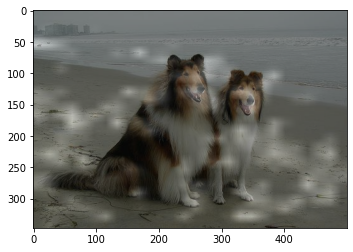

In [47]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

#### conv4_block3Ïùò CAMÏù¥ÎØ∏ÏßÄÎ•º Ï∂úÎ†•

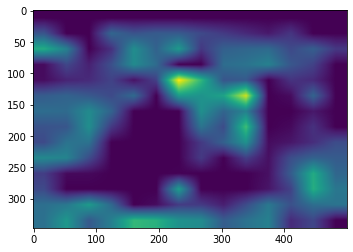

In [48]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

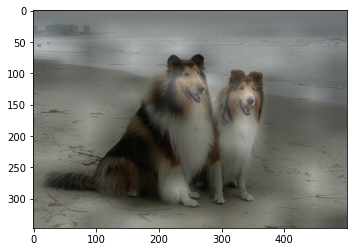

In [49]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### conv5_block3 Ïùò CAM Ïù¥ÎØ∏ÏßÄÎ•º Ï∂úÎ†•

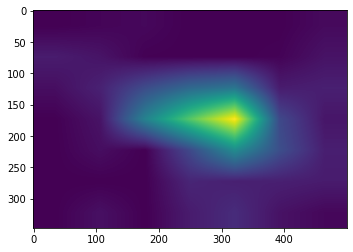

In [50]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

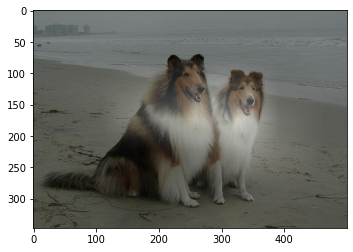

In [51]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

ÌôïÏã§Ìûà Î†àÏù¥Ïñ¥Í∞Ä ÏåìÏùºÏàòÎ°ù CAM Ïù¥ÎØ∏ÏßÄÍ∞Ä ÌôúÏÑ±ÌôîÎêòÎäî Î∂ÄÎ∂ÑÏù¥ Î™ÖÌôïÌï¥ÏßêÏùÑ Ïïå Ïàò ÏûàÏóàÏäµÎãàÎã§.

## **4. Î∞îÏö¥Îî© Î∞ïÏä§ Íµ¨ÌïòÍ∏∞**
> Ï†úÏãúÎêú ÏΩîÎìúÎ•º Ï∞∏Í≥†Ìï¥, ÏßÅÏ†ë Grad-CAMÏúºÎ°ú ÏñªÏùÄ CAMÏùÑ ÌÜµÌï¥ÏÑú Î∞îÏö¥Îî© Î∞ïÏä§Î•º ÏñªÏñ¥Î≥¥ÏÑ∏Ïöî.


67


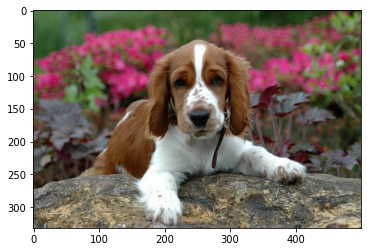

In [54]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

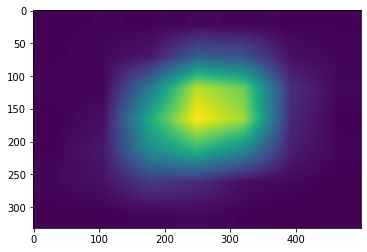

In [55]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

Ïù¥Ï†Ñ Ïä§ÌÖùÏóêÏÑú ÎßåÎì§ÏóàÎçò  `generate_cam()`ÏùÑ ÌôúÏö©Ìï¥ÏÑú cam Ïù¥ÎØ∏ÏßÄÎ•º ÎΩëÏïòÏäµÎãàÎã§.  
ÏïÑÎûò `get_bbox()`Ìï®ÏàòÎäî 
1. Î∞îÏö¥Îî© Î∞ïÏä§Î•º ÎßåÎì§Í∏∞ ÏúÑÌï¥ÏÑú  socre_threshÎ•º Î∞õÏïÑ Ïó≠ÏπòÍ∞í Ïù¥ÌïòÏùò Î∞îÏö¥Îî©Î∞ïÏä§Îäî ÏóÜÏï±ÎãàÎã§.  
2. opencvÏùò `findContours()`ÏôÄ `minAreaRect()`Î°ú ÏÇ¨Í∞ÅÌòïÏùÑ Ï∞æÏäµÎãàÎã§.   
    rotated_rectÎùºÎäî ÌöåÏ†ÑÎêú Î∞îÏö¥Îî© Î∞ïÏä§Î•º ÏñªÏùÑ Ïàò ÏûàÏäµÎãàÎã§. 
3. `boxpoints()`Î°ú Ïù¥Î•º Íº≠ÏßÄÏ†êÏúºÎ°ú Î∞îÍæ∏Ïñ¥ Ï§çÎãàÎã§. 
4. int ÏûêÎ£åÌòïÏúºÎ°ú Î≥ÄÌôò!

In [61]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)

    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('üöó=3')

üöó=3


> ÏúÑÏóêÏÑú ÏñªÏùÄ Î∞îÏö¥Îî© Î∞ïÏä§Î•º ÏãúÍ∞ÅÌôîÌï¥ Î≥¥ÏÑ∏Ïöî.

In [62]:
rect = get_bbox(cam_image)
rect

array([[ 91,  29],
       [441,  29],
       [441, 296],
       [ 91, 296]])

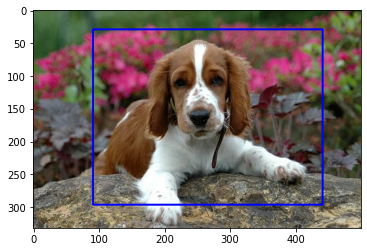

In [64]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

tada~

## **5. IoU Íµ¨ÌïòÍ∏∞**
> **Ï†ïÎãµ Î∞îÏö¥Îî© Î∞ïÏä§(ground truth) ÏôÄ ÏòàÏ∏°Í∞í Î∞îÏö¥Îî© Î∞ïÏä§(prediction box)** Îëê Í∞ÄÏßÄÎ•º Ïù¥Ïö©Ìï¥ÏÑú IoUÎ•º Í≥ÑÏÇ∞ÌïòÎäî `get_iou()` Ìï®ÏàòÎ•º ÎßåÎì§Ïñ¥ Ï£ºÏÑ∏Ïöî.

ÏïÑÍπå Ï∂îÏ∂úÎêú bbox Ï¢åÌëúÎäî normalizedÌòïÌÉúÎ°ú Ï∂îÏ∂úÎêêÏäµÎãàÎã§. (y_min, x_min, y_max, x_max)  
minmax ÌòïÌÉúÎ°ú ÏπòÌôòÌï©ÎãàÎã§!

In [65]:
rect

array([[ 91,  29],
       [441,  29],
       [441, 296],
       [ 91, 296]])

In [68]:
print(rect[:,0]  )
# xÎ•º Ï≠â ÎΩëÏùÄÍ≤®
print(rect[:,1]  )
# yÎ•º Ï≠â ÎΩëÏùÄÍ≤®

[ 91 441 441  91]
[ 29  29 296 296]


In [69]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),
        # yÎΩëÏùÄÍ±∞Ï§ëÏóêÏÑú ÏµúÏÜå = y_min
        rect[:,0].min()/float(image.shape[1]),  
        # xÎΩëÏùÄÍ±∞Ï§ëÏóêÏÑú ÏµúÏÜå = x_min
        rect[:,1].max()/float(image.shape[0]), 
        # y ÎΩëÏùÄÍ±∞Ï§ëÏóêÏÑú ÏµúÎåÄ = y_max
        rect[:,0].max()/float(image.shape[1]) 
        # x ÎΩëÏùÄÍ±∞Ï§ëÏóêÏÑú ÏµúÎåÄ = x_max
    ]
    return bbox

print("üöó=3")

üöó=3


In [70]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.08734939759036145, 0.182, 0.891566265060241, 0.882]

ground truth bboxÎ•º ÌôïÏù∏Ìï¥ Î¥ÖÎãàÎã§.

In [71]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

Ïù¥Î•º Î∞îÌÉïÏúºÎ°ú iouÎ•º Í≥ÑÏÇ∞Ìï¥Î¥ÖÎãàÎã§.

In [72]:
def get_iou(gt_bbox, pred_bbox):
    iou = None
    y_min = max(gt_bbox[0], pred_bbox[0])
    x_min= max(gt_bbox[1], pred_bbox[1])
    y_max = min(gt_bbox[2], pred_bbox[2])
    x_max = min(gt_bbox[3], pred_bbox[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    boxBArea = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou
print("üöó=3")

üöó=3


2. CAMÍ≥º Grad-CAMÏúºÎ°ú ÏñªÏùÄ Î∞îÏö¥Îî© Î∞ïÏä§ÏôÄ Ï†ïÎãµ Î∞îÏö¥Îî© Î∞ïÏä§ÏôÄÏùò IoUÎ•º Í∞ÅÍ∞Å ÎπÑÍµêÌï¥ Î¥ÖÏãúÎã§.

In [73]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7425216461282889

Ïûò ÎßûÎÑ§Ïö©

## **üç§ Î£®Î∏åÎ¶≠**
| ÌèâÍ∞ÄÎ¨∏Ìï≠ | ÏÉÅÏÑ∏Í∏∞Ï§Ä | ÌïôÏäµÍ≤∞Í≥º |
|:---:|:---:|:---:|
| 1. CAMÏùÑ ÏñªÍ∏∞ ÏúÑÌïú Í∏∞Î≥∏Î™®Îç∏Ïùò Íµ¨ÏÑ±Í≥º ÌïôÏäµÏù¥ Ï†ïÏÉÅ ÏßÑÌñâÎêòÏóàÎäîÍ∞Ä? | ResNet50 + GAP + DenseLayer Í≤∞Ìï©Îêú CAM Î™®Îç∏Ïùò ÌïôÏäµÍ≥ºÏ†ïÏù¥ ÏïàÏ†ïÏ†ÅÏúºÎ°ú ÏàòÎ†¥ÌïòÏòÄÎã§. | O |
| 2. Î∂ÑÎ•òÍ∑ºÍ±∞Î•º ÏÑ§Î™Ö Í∞ÄÎä•Ìïú Class activation mapÏùÑ ÏñªÏùÑ Ïàò ÏûàÎäîÍ∞Ä? | CAM Î∞©ÏãùÍ≥º Grad-CAM Î∞©ÏãùÏùò class activation mapÏù¥ Ï†ïÏÉÅÏ†ÅÏúºÎ°ú ÏñªÏñ¥ÏßÄÎ©∞, ÏãúÍ∞ÅÌôîÌïòÏòÄÏùÑ Îïå Ìï¥Îãπ objectÏùò Ï£ºÏöî ÌäπÏßï ÏúÑÏπòÎ•º Ïûò Î∞òÏòÅÌïúÎã§. | O |
| 3. Ïù∏ÏãùÍ≤∞Í≥ºÏùò ÏãúÍ∞ÅÌôî Î∞è ÏÑ±Îä• Î∂ÑÏÑùÏùÑ Ï†ÅÏ†àÌûà ÏàòÌñâÌïòÏòÄÎäîÍ∞Ä? | CAMÍ≥º Grad-CAM Í∞ÅÍ∞ÅÏóê ÎåÄÌï¥ ÏõêÎ≥∏Ïù¥ÎØ∏ÏßÄÌï©ÏÑ±, Î∞îÏö¥Îî©Î∞ïÏä§, IoU Í≥ÑÏÇ∞ Í≥ºÏ†ïÏùÑ ÌÜµÌï¥ CAMÍ≥º Grad-CAMÏùò object localization ÏÑ±Îä•Ïù¥ ÎπÑÍµêÎ∂ÑÏÑùÎêòÏóàÎã§. | O |

## **‚úç ÌöåÍ≥†**

* grad-camÏóêÏÑúÎäî layerÎßàÎã§ activation mapÏùÑ ÎΩëÏïÑÎ≥º Ïàò ÏûàÏñ¥ÏÑú Îß§Ïö∞ ÎèÑÏõÄÎê† Í≤É Í∞ôÏïòÎã§. Í∞Å Î†àÏù¥Ïñ¥ÎßàÎã§ Î¨¥ÏóáÏùÑ Î≥¥Í≥† ÏûàÎäîÏßÄ ÎÇòÎèÑ Î≥º Ïàò ÏûàÏúºÎãàÍπå!

* Î¨∏ÌÉúÏÑ≠ÍµêÏàòÎãòÏùò XAI Í∞ïÏùòÎ•º Îì§ÏùÄ Ï†ÅÏù¥ ÏûàÏóàÎäîÎç∞ Í±∞Í∏∞ÏÑú Î¥§Îçò CAM, GRAD-CAMÏùÑ Íµ¨ÌòÑÌï¥ Î≥º Ïàò ÏûàÏñ¥ÏÑú Ï¢ãÏïòÎã§. 
    * RISE, LIMEÍ≥º Í∞ôÏùÄ Îã§Î•∏ Î™®Îç∏ÎèÑ ÏÇ¨Ïö©Ìï¥Î≥¥Í≥† Ïã∂Îã§.  
    ÌôïÏã§Ìûà Ïù¥ ÎëêÍ∞úÎäî CAMÍ≥º ÎπÑÍµêÌï¥ÏÑú Îçî clearÌïú mapÏùÑ Ï∂úÎ†•ÌñàÎäîÎç∞, Í∑∏ÎßåÌÅº Í≥ÑÏÇ∞ÎπÑÏö©Ïù¥ ÌÅ¨Í≥† Í≥ÑÏÇ∞ Î≥µÏû°ÎèÑÍ∞Ä Ïª§ÏßÑÎã§Îäî Îã®Ï†êÏù¥ ÏûàÏóàÎã§.

![image](https://user-images.githubusercontent.com/108614874/196870024-a78d16d4-5c0e-4a28-b89c-878621eee22b.png)
Ï∂úÏ≤ò: ÏÑúÏö∏ÎåÄÌïôÍµê Ï†ÑÍ∏∞Ï†ïÎ≥¥Í≥µÌïôÎ∂Ä Î¨∏ÌÉúÏÑ≠ ÍµêÏàòÎãò (M.IN.D Lab)

* ÎãπÏó∞ÌïòÍ≤åÎèÑ 2 epoch ÌïôÏäµÏãúÌÇ® Î™®Îç∏Í≥º 50 epoch ÌïôÏäµÏãúÌÇ® Î™®Îç∏Ïùò iou Ï∞®Ïù¥Í∞Ä ÌôïÏó∞ÌñàÎã§. 
* XAI Î∂ÑÏïºÏóê ÎåÄÌï¥ Í≤âÌï•Í∏∞ÏßÄÎßå Î∞∞ÏõåÎ≥º Ïàò ÏûàÏñ¥ÏÑú Ï¢ãÏïòÎã§. ÏÇ¨Ïã§ ÎÇ¥Í∞Ä CVÎ•º ÏÑ†ÌÉùÌïú Ïù¥Ïú† Ï§ë ÌïòÎÇòÎèÑ ÏßÅÍ¥ÄÏ†ÅÏúºÎ°ú ÏãúÍ∞ÅÌôîÍ∞Ä Í∞ÄÎä•ÌïòÎã§Îäî Ï†êÏù¥ÏóàÎäîÎç∞, CAMÏù¥ ÌïôÏäµÍ≥ºÏ†ï Ï§ë ÌôúÏÑ±ÌôîÎêòÎäî ÏòÅÏó≠ÏùÑ ÏãúÍ∞ÅÌôîÌï¥ÏÑú Î™®Îç∏Ïù¥ Ïñ¥Îñ§Í≥≥ÏùÑ Î≥¥Í≥† Ïñ¥Îñ§ ÌÅ¥ÎûòÏä§ÏûÑÏùÑ ÏßêÏûëÌïòÍ≥† ÏûàÎäîÏßÄ Ïïå Ïàò ÏûàÎã§Îãà ~~


* GAPÎ•º ÏÇ¨Ïö©ÌïòÎäîÍ≤å Ï§ëÏöîÌñàÎã§. FC layerÎ°ú Íæπ„Ñ±Íæπ ÎàåÎü¨ÏÑú ÏòàÏ∏°Í≤∞Í≥ºÎ•º ÎÇ¥ÎäîÍ≤å ÏïÑÎãàÎùº average poolingÏùÑ Ïù¥Ïö©Ìï¥ÏÑú Í∞Å ÌÅ¥ÎûòÏä§Î≥Ñ ÌôïÎ•†ÏùÑ ÏñªÏñ¥ Ìï¥ÏÑùÏùÑ ÏâΩÍ≤åÌñàÎã§~!

### **üîñ Ï∞∏Í≥†Î¨∏Ìóå**

* [unit8? uint8!](https://stackoverflow.com/questions/66023331/try-to-make-black-image-but-getting-error-for-np-unit8)